In [1]:
import numpy as np
import pandas as pd

# 1. Data

In [2]:
from sklearn.datasets import fetch_openml

In [3]:
dataset = fetch_openml("mnist_784", version=1)
dataset.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

## 1.1. Features

In [4]:
X: pd.DataFrame = dataset["data"]

In [5]:
X.shape

(70000, 784)

In [6]:
X.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 1.2. Target

In [7]:
y: pd.DataFrame = dataset["target"]

In [8]:
y.shape

(70000,)

In [9]:
y.head()

0    5
1    0
2    4
3    1
4    9
Name: class, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

In [10]:
y.value_counts()

class
1    7877
7    7293
3    7141
2    6990
9    6958
0    6903
6    6876
8    6825
4    6824
5    6313
Name: count, dtype: int64

## 1.3. Instance

In [11]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [12]:
instance = X.iloc[0].to_numpy()

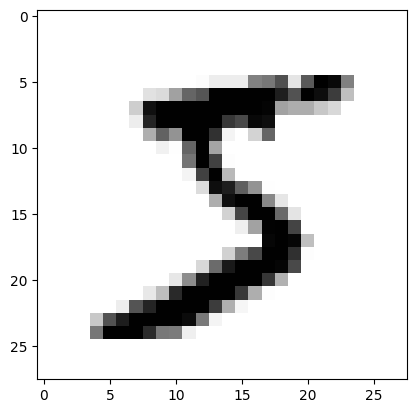

In [13]:
plt.imshow(instance.reshape(28, 28), cmap="binary")
plt.show()

# 2. Binary

## 2.1. Train

Bin class for the number five

In [14]:
SPLIT = 60000

In [15]:
X_train, X_test, y_train, y_test = X[:SPLIT], X[SPLIT:], y[:SPLIT], y[SPLIT:]

In [16]:
y_train_5, y_test_5 = y_train.apply(lambda x: int(x) == 5), y_test.apply(
    lambda x: int(x) == 5
)

### 2.1.1. Baseline

In [17]:
from sklearn.base import BaseEstimator

In [18]:
class NeverFiveClassifier(BaseEstimator):
    def fit(self, X, y=None):
        pass

    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [19]:
baseline = NeverFiveClassifier()

Compute accuracy with cross validation 

In [20]:
from sklearn.model_selection import cross_val_score

In [21]:
scores = cross_val_score(baseline, X_train, y_train_5, cv=3, scoring="accuracy")

In [22]:
scores

array([0.91125, 0.90855, 0.90915])

### 2.1.2. Model

In [23]:
from sklearn.linear_model import LogisticRegression

In [24]:
model = LogisticRegression(max_iter=1000, solver="newton-cholesky")

Compute accuracy with cross validation 

In [25]:
from sklearn.model_selection import cross_val_score

In [26]:
scores = cross_val_score(model, X_train, y_train_5, cv=3, scoring="accuracy")

In [27]:
scores

array([0.97405, 0.9712 , 0.97275])

## 2.2. Validate

### 2.2.1. Metrics

Compute the predictions per instance when they were in the validation fold

In [28]:
from sklearn.model_selection import cross_val_predict

In [29]:
preds = cross_val_predict(model, X_train, y_train_5, cv=3)

In [30]:
preds.shape

(60000,)

Compute the confusion matrix (tn, fp, fn, tp)

In [31]:
from sklearn.metrics import confusion_matrix

In [32]:
matrix = confusion_matrix(y_train_5, y_train_5)  # sanity check
matrix

array([[54579,     0],
       [    0,  5421]])

In [33]:
matrix = confusion_matrix(y_train_5, preds)
matrix

array([[53957,   622],
       [ 1018,  4403]])

In [34]:
tn, fp, fn, tp = matrix.flatten()

Compute metrics

In [35]:
metrics = dict(acc=(tn + tp) / len(y_train_5), pre=tp / (tp + fp), rec=tp / (tp + fn))
metrics[" f1"] = (
    2 * (metrics["pre"] * metrics["rec"]) / (metrics["pre"] + metrics["rec"])
)

In [36]:
for k in metrics.keys():
    print(k, metrics[k])

acc 0.9726666666666667
pre 0.8762189054726368
rec 0.8122117690463014
 f1 0.8430021060693088


### 2.2.2. Precision vs recall tradeoff

Draw precision vs recall curve

In [37]:
preds = cross_val_predict(model, X_train, y_train_5, cv=3, method="decision_function")

In [38]:
preds.shape

(60000,)

In [39]:
from sklearn.metrics import precision_recall_curve

In [40]:
pre, rec, thr = precision_recall_curve(y_train_5, preds)
dif = abs(pre-rec)

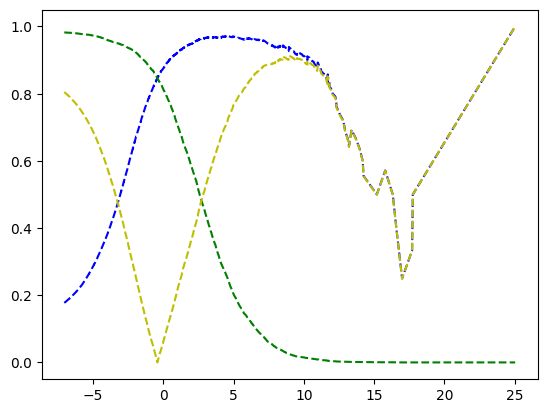

In [41]:
plt.plot(thr[-30000:-1], pre[-30000:-1], "b--", label="Precision")
plt.plot(thr[-30000:-1], rec[-30000:-1], "g--", label="Recall")
plt.plot(thr[-30000:-1], dif[-30000:-1], "y--", label="Diff")
plt.show()

Use a threshold where precision and recall are equal

In [42]:
eq_thr_idx = np.argmin(dif)

In [43]:
pre[eq_thr_idx], rec[eq_thr_idx]

(np.float64(0.8459693783434791), np.float64(0.8459693783434791))

In [44]:
eq_thr = thr[eq_thr_idx]
eq_thr

np.float64(-0.43224455099739384)

Recalculate confusion matrix

In [45]:
matrix = confusion_matrix(y_train_5, (preds >= eq_thr))
matrix

array([[53744,   835],
       [  835,  4586]])

Recalculate metrics

In [46]:
tn, fp, fn, tp = matrix.flatten()

In [47]:
metrics = dict(acc=(tn + tp) / len(y_train_5), pre=tp / (tp + fp), rec=tp / (tp + fn))
metrics[" f1"] = (
    2 * (metrics["pre"] * metrics["rec"]) / (metrics["pre"] + metrics["rec"])
)

In [48]:
for k in metrics.keys():
    print(k, metrics[k])

acc 0.9721666666666666
pre 0.8459693783434791
rec 0.8459693783434791
 f1 0.8459693783434791


### 2.2.3. Receiver operating characteristic

Draw ROC curve: FPR (1-TNR) vs TPR (Recall)

In [49]:
from sklearn.metrics import roc_curve, roc_auc_score

In [50]:
fpr, tpr, thr = roc_curve(y_train_5, preds)

In [51]:
roc_auc_score(y_train_5, preds)

np.float64(0.973290900363017)

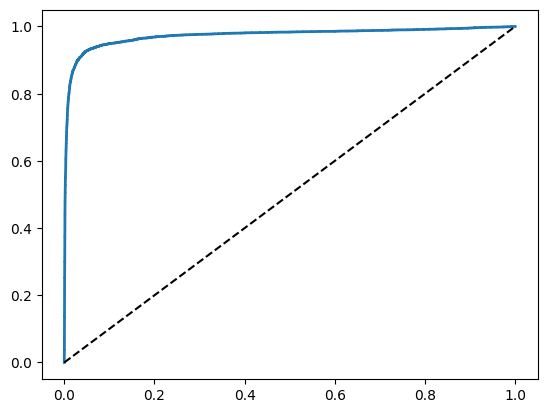

In [52]:
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], "k--")
plt.show()

## 2.3. Test

### 2.3.1. Fit

In [53]:
model.fit(X_train, y_train_5)

LogisticRegression(max_iter=1000, solver='newton-cholesky')

Pixel weight (black smallest, white highest)

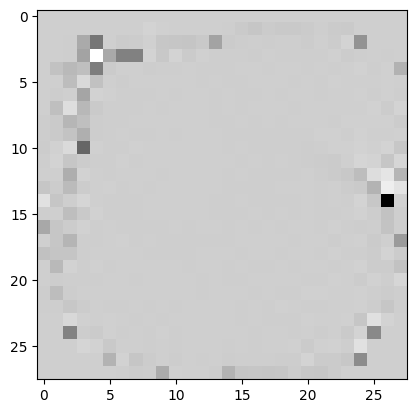

In [54]:
plt.imshow(model.coef_.reshape(28, 28), cmap="gist_gray")
plt.show()

### 2.3.2. Metrics

In [55]:
preds = model.decision_function(X_test) # weighted sum of the features

In [56]:
preds = preds >= eq_thr

In [57]:
matrix = confusion_matrix(y_test_5, preds)
matrix

array([[8996,  112],
       [ 124,  768]])

In [58]:
matrix = confusion_matrix(y_test_5, preds)
matrix

array([[8996,  112],
       [ 124,  768]])

In [59]:
tn, fp, fn, tp = matrix.flatten()

In [60]:
metrics = dict(acc=(tn + tp) / len(y_test_5), pre=tp / (tp + fp), rec=tp / (tp + fn))
metrics[" f1"] = (
    2 * (metrics["pre"] * metrics["rec"]) / (metrics["pre"] + metrics["rec"])
)

In [61]:
for k in metrics.keys():
    print(k, metrics[k])

acc 0.9764
pre 0.8727272727272727
rec 0.8609865470852018
 f1 0.8668171557562077
